# Определение возраста покупателей

## Постановка задачи

### Описание

<div>Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. <br /> Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
<li> Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
<li> Контролировать добросовестность кассиров при продаже алкоголя.<br /> 
Требуется построить модель, которая по фотографии определит приблизительный возраст человека. <br /> 
</div>      
<div>
В качестве обучающих данных используется набор фотографий людей с указанием возраста.
</div>    

### Описание данных

Данные взяты с сайта ChaLearn Looking at People. Они находятся в папке /datasets/faces/.<br /> 
Папка со всеми изображениями: /final_files<br/> 
Файл  с данными о фотографиях labels.csv
Значения полей:
- file_name - имя файла с фотографией
- real_age - приблизительный возраст.

## Исследовательский анализ данных

### Предварительные работы

### Загрузка библиотек

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings

from scipy.stats import norm
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
# Отключение warning
warnings.filterwarnings('ignore')
pd.options.mode.chained_assignment = None
#Формат float
pd.options.display.float_format = '{:,.2f}'.format
# Сброс ограничений на число столбцов
pd.options.display.max_columns = None

### Загрузка данных

In [3]:
labels = pd.read_csv('/datasets/faces/labels.csv')

In [4]:
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


### Описание данных:

In [5]:
labels.describe()

,real_age
count,"7,591.00"
mean,31.20
std,17.15
min,1.00
25%,20.00
50%,29.00
75%,41.00
max,100.00


In [6]:
xmin = labels['real_age'].describe()['min']
xmax = labels['real_age'].describe()['max']
mean = labels['real_age'].describe()['mean']
std = labels['real_age'].describe()['std']
accuracy = 1
xpoints = int((xmax-xmin)/accuracy + 1)

Количество уникальных значений возрастов:

In [7]:
ages = np.sort(labels['real_age'].unique())
len(ages)

97

In [8]:
not_in_ages =[]
for i in range(100):
    if (i+1) not in ages:
        not_in_ages.append(i+1)
print('В датасете отсутствуют фотографии людей возрастов:', not_in_ages)        

В датасете отсутствуют фотографии людей возрастов: [92, 98, 99]


### График распределения возраста в выборке:

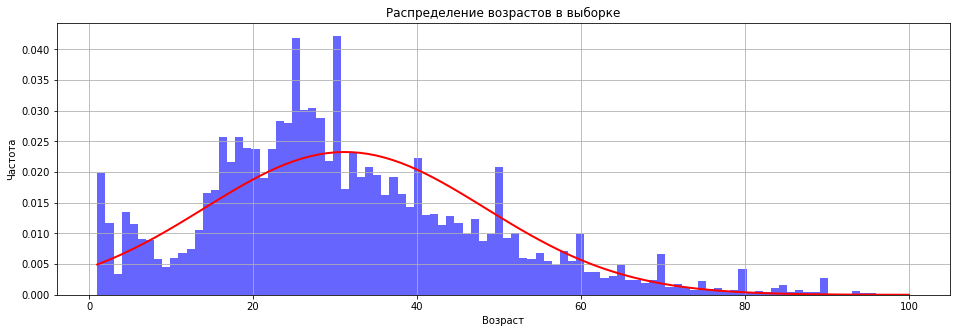

In [9]:
fig, ax = plt.subplots(figsize=(16,5))
grafic_x = [ round(x, 1) for x in np.linspace(xmin, xmax, xpoints)]
labels.plot(kind = 'hist', bins=xpoints, density=True, alpha=0.6, color='b', grid=True, ax=ax)
line = norm.pdf(grafic_x, mean, std)
ax.plot(grafic_x, line, linewidth=2.0, color='r')
ax.set(title = 'Распределение возрастов в выборке', xlabel = 'Возраст', ylabel = 'Частота')
ax.get_legend().remove()
plt.show()


На графике видно, что присутствуют выбросы, соответствующие 1, 25, 30, 40, 50, 60, 70, 80 и 90 годам. Скорее всего, для части фотографий возраст был указан приблизительно.<br />
К сожалению, из-за отсутствия других признаков, у нас нет возможности уточнить или удалить неточные данные.

### Анализ фотографий

Посмотрим на 15 первых фотографий:

In [10]:
labels_probe = labels.head(15)
labels_probe

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17
5,000005.jpg,27
6,000006.jpg,24
7,000007.jpg,43
8,000008.jpg,26
9,000009.jpg,39


In [11]:
datagen = ImageDataGenerator(rescale=1./255)
gen_flow_probe = datagen.flow_from_dataframe(
        dataframe=labels_probe,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        seed=12345)

Found 15 validated image filenames.


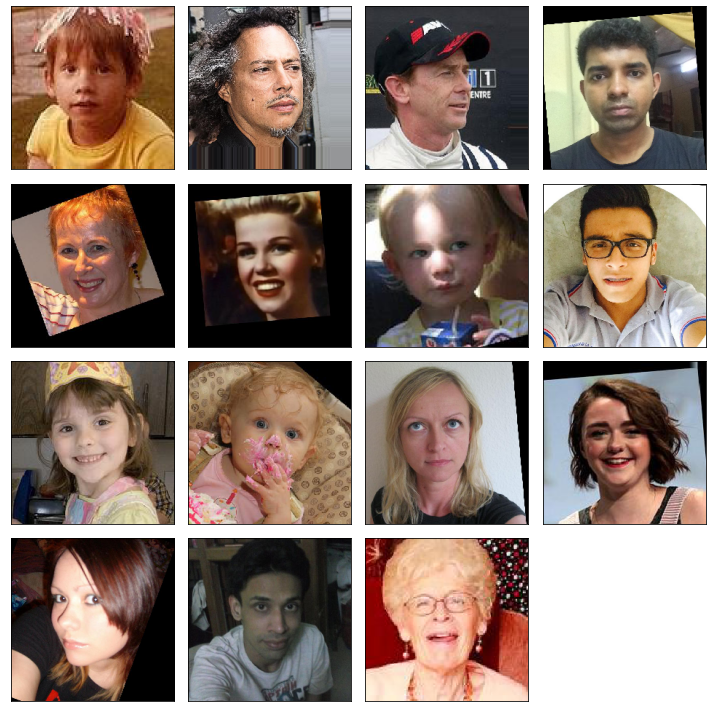

In [12]:
features, target = next(gen_flow_probe)

fig = plt.figure(figsize=(10,10))
for i in range(len(labels_probe)):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

### Выводы анализа данных

1. Датасет состоит из 7591 фотографии людей в почти всех возрастов в диапазоне от 1 до 100 лет (кроме 92, 98 и 99 лет). Часть возрастов указана приблизительно.
2. Распределение возрастов близко к нормальному со смещением вправо, медианый возраст - 29 лет, средний - 31,2, большая часть людей находится в возрасте от 21 до 40 лет.
3. Фотографии цветные, в разных ракурсах, часть из них повернута с целью добиться вертикальности положения головы.
4. На снимках могут присутствовать предметы, закрывающие часть лица, головные уборы.
5. Фотографии сделаны при разном по интенсивности, направленности и цветовой температуре освещении

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

### Код

```python
import pandas as pd

from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import (
    GlobalAveragePooling2D, 
    Dense)
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam


def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    
    datagen = ImageDataGenerator(
        validation_split=0.25, 
        horizontal_flip=True, 
        rescale=1./255)
    
    train_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_gen_flow

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    
    datagen = ImageDataGenerator(
        validation_split=0.25, 
        rescale=1./255)
    
    test_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_gen_flow

def create_model(input_shape):

    resnet = ResNet50(input_shape=input_shape,
                    weights='imagenet', 
                    include_top=False)
    model = Sequential()
    model.add(resnet)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(lr=0.00025)
    model.compile(optimizer=optimizer, loss='mean_squared_error',
                  metrics=['mae'])


    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=6,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, 
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

```

### Результат обучения:

```
Found 5694 validated image filenames.
Found 1897 validated image filenames.

Train for 356 steps, validate for 119 steps
Epoch 1/6
356/356 - 61s - loss: 188.9929 - mae: 10.3181 - val_loss: 358.4223 - val_mae: 14.1490
Epoch 2/6
356/356 - 50s - loss: 99.8177 - mae: 7.6035 - val_loss: 178.0786 - val_mae: 9.9024
Epoch 3/6
356/356 - 50s - loss: 78.1136 - mae: 6.7667 - val_loss: 220.1799 - val_mae: 11.5838
Epoch 4/6
356/356 - 50s - loss: 64.0023 - mae: 6.0582 - val_loss: 86.1458 - val_mae: 6.9059
Epoch 5/6
356/356 - 51s - loss: 48.6315 - mae: 5.3426 - val_loss: 148.8830 - val_mae: 9.8464
Epoch 6/6
356/356 - 49s - loss: 39.2204 - mae: 4.8571 - val_loss: 78.7294 - val_mae: 6.7698

119/119 - 11s - loss: 78.7294 - mae: 6.7698
Test MAE: 6.7698
```

```
Found 5694 validated image filenames.
Found 1897 validated image filenames.

Train for 356 steps, validate for 119 steps
Epoch 1/6
356/356 - 67s - loss: 192.1341 - mae: 10.3305 - val_loss: 340.5624 - val_mae: 13.7299
Epoch 2/6
356/356 - 42s - loss: 106.5757 - mae: 7.8850 - val_loss: 191.8180 - val_mae: 10.4324
Epoch 3/6
356/356 - 43s - loss: 76.7293 - mae: 6.6668 - val_loss: 100.2330 - val_mae: 7.7855
Epoch 4/6
356/356 - 42s - loss: 60.8434 - mae: 5.9008 - val_loss: 94.2341 - val_mae: 7.4185
Epoch 5/6
356/356 - 44s - loss: 48.4855 - mae: 5.2818 - val_loss: 77.8585 - val_mae: 6.4679
Epoch 6/6
356/356 - 43s - loss: 38.6534 - mae: 4.7548 - val_loss: 92.8390 - val_mae: 7.0576

119/119 - 10s - loss: 92.8390 - mae: 7.0576
Test MAE: 7.0576
```

## Анализ обученной модели

1. Время обучения модели - меньше 7 минут
2. Модель незначительно переучена, что характерно для нейронных сетей с большим числом слоёв.
3. Погрешность меньше 5 лет на обучающей и меньше 7 лет на валидационной выборке можно считать небольшой с учётом небольшого набора данных и неточных данных по возрасту (график распределения возрастов показывает явную подгонку под "круглые" возраста).
4. При необходимости данные модели можно улучшить путем увеличения обучающего набора данных, более точных данных по возрастам, увелечения количества эпох и подбора шага оптимайзера.